# INF0429 - Robótica
## Lab02 - Localizaçao com LiDAR

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore
from IPython import display
import tqdm

In [2]:
# Mapa do ambiente
landmarks = np.array([[ 3.00085905, -0.62390064],
                      [ 3.89524457,  0.36092648],
                      [ 3.9005231 ,  2.80069002],
                      [ 3.06272609,  2.80621234],
                      [ 3.04464186,  3.41088797],
                      [-1.14314437,  3.41088816],
                      [-1.15656156,  2.07743863],
                      [-2.49979193,  2.06182513],
                      [-2.50508263, -0.62015044]], dtype=np.float32)

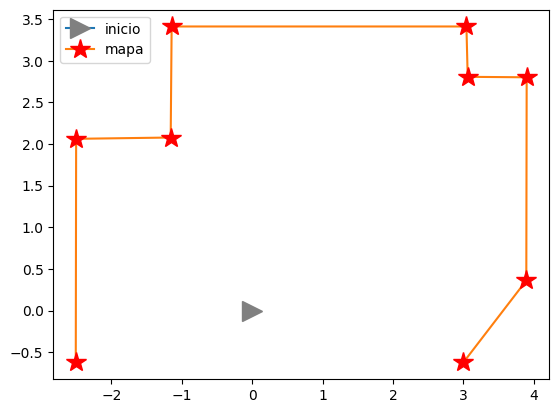

In [3]:
fig, ax = plt.subplots()
ax.plot(0, 0, marker='>', markersize=15, mec='gray', mfc='gray', label='inicio')
ax.plot(landmarks[:, 0], landmarks[:, 1], marker='*', markersize=15, mec='r', mfc='r', label='mapa')
ax.legend()
plt.show()

### Funções importantes

In [4]:
# Classes
class Robot(object):
    pass

class Sensor(object):
    pass

In [5]:
def Polar2Cartesian(r, alpha):
    return np.transpose(r * np.array([np.cos(alpha), \
                                      np.sin(alpha)]))

def getDistance(P, Ps, Pe): # point to line distance, where the line is given with points Ps and Pe
    if np.all(np.equal(Ps, Pe)):
        return np.linalg.norm(P - Ps)

    return np.divide(np.abs(np.linalg.norm(np.cross(Pe - Ps, Ps - P))), \
                     np.linalg.norm(Pe - Ps))

def GetMostDistant(P):
    dmax = 0
    index = -1
    for i in range(1, P.shape[0]):
        d = getDistance(P[i,:], P[0,:], P[-1,:])
        if (d > dmax):
            index = i
            dmax = d

    return dmax, index

def SplitAndMerge(P, threshold):
    d, ind = GetMostDistant(P)

    if (d > threshold):
        P1 = SplitAndMerge(P[:ind+1, :], threshold) # split and merge left array
        P2 = SplitAndMerge(P[ind:, :], threshold) # split and merge right array
        # there are 2 "d" points, so exlude 1 (for example from 1st array)
        points = np.vstack((P1[:-1, :], P2))
    else:
        points = np.vstack((P[0, :], P[-1, :]))

    return points

### Configurando parâmetros dos sensores LiDAR e odom

In [6]:
typestore = get_typestore(Stores.ROS2_FOXY)

# create reader instance and open for reading
with Reader('./albot_tours0/') as reader:    
    # iterate over messages
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/scan': # LiDAR @ 10 Hz
            # typestore = get_typestore(Stores.ROS2_FOXY)
            lidar = typestore.deserialize_cdr(rawdata, connection.msgtype)

            # Lidar parametros do feixe
            lidar_th_min = lidar.angle_min # -90 deg
            lidar_th_max = lidar.angle_max # +90 deg
            lidar_th_step = lidar.angle_increment # +1 deg
            lidar_angles = np.arange(lidar_th_min, \
                                     lidar_th_max + lidar_th_step, \
                                     lidar_th_step) # radianos
            
            break
            
        if connection.topic == '/imu': # IMU @ 100 Hz
            # typestore = get_typestore(Stores.ROS2_FOXY)
            imu = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            # Covariancia do acelerometro
            Q_acc = imu.linear_acceleration_covariance.reshape((3, 3)).astype(np.float32)
            
            # Covariancia do giroscopio
            Q_gyr = imu.angular_velocity_covariance.reshape((3, 3)).astype(np.float32)
            
            # Vetor de ruido dos sensores inerciais
            w_imu = np.sqrt(np.array([[Q_acc[0, 0]],
                                      [Q_acc[1, 1]],
                                      [Q_gyr[2, 2]]]))
            
        if connection.topic == '/odom': # odometry @ 100 Hz
            odom = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            # Vetor de ruido dos encoders
            w_odom = np.sqrt(np.diag(np.array(odom.twist.covariance).reshape(6, 6)))[:, np.newaxis] # linear, angular
            

### Laço de processamento on-line

ODOM
IMU
ODOM
IMU
ODOM
IMU
ODOM
IMU
ODOM
IMU
ODOM
IMU
ODOM
IMU
ODOM
IMU
ODOM
IMU
ODOM
IMU
LIDAR


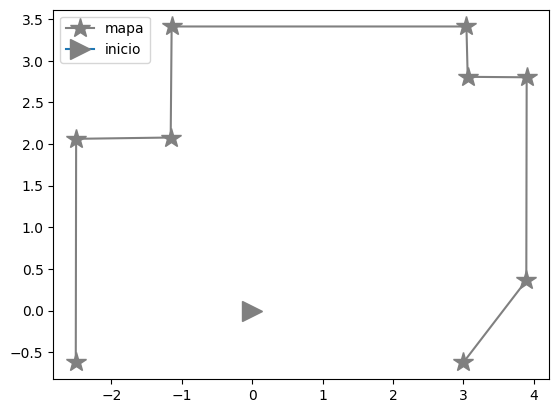

In [7]:
# Reference: https://answers.ros.org/question/358686/how-to-read-a-bag-file-in-ros2/

robot = Robot()

# Plots
fig, ax = plt.subplots()
plt.plot(landmarks[:, 0], landmarks[:, 1], marker='*', markersize=15, color='gray', mec='gray', mfc='gray', label='mapa')
plt.plot(0, 0, marker='>', markersize=15, mec='gray', mfc='gray', label='inicio')
plt.legend()

threshold_SM = 0.025 # Split & Merge threshold

typestore = get_typestore(Stores.ROS2_FOXY)

# create reader instance and open for reading
with Reader('./albot_tours0/') as reader:
    # iterate over messages
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/scan':
            print('LIDAR')
            lidar = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            # Coordenadas 2D dos feixes
            lidar_x, lidar_y = lidar.ranges * [np.cos(lidar_angles), \
                                               np.sin(lidar_angles) ]
            
            # Split & Merge
            P = Polar2Cartesian(lidar.ranges, lidar_angles)
            lidar_corners = SplitAndMerge(P, threshold_SM)
            
            # Plots
            # plt.plot(lidar_x, lidar_y, 'b.')
            # plt.plot(lidar_corners[:, 0], lidar_corners[:, 1], 'or')
            # display.display(fig)
            # display.clear_output(wait=True)
            break

        if connection.topic == '/imu':
            print('IMU')
            imu = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            # Accelerometer data
            acc = np.array([imu.linear_acceleration.x, \
                            imu.linear_acceleration.y, \
                            imu.linear_acceleration.z], dtype=np.float32)
            
            # Gyroscope data
            gyr = np.array([imu.angular_velocity.x, \
                            imu.angular_velocity.y, \
                            imu.angular_velocity.z], dtype=np.float32)
            
        if connection.topic == '/odom': # wheel odometry @ 100 Hz
            print('ODOM')
            odom = typestore.deserialize_cdr(rawdata, connection.msgtype)
            # groun truth
            robot.pose = np.array([odom.pose.pose.position.x, \
                                   odom.pose.pose.position.y, \
                                   odom.pose.pose.position.z])
            # Linear
            robot.linear = np.array([odom.twist.twist.linear.x, \
                                    odom.twist.twist.linear.y, \
                                    odom.twist.twist.linear.z], dtype=np.float32)
            # Angular
            robot.angular = np.array([odom.twist.twist.angular.x, \
                                      odom.twist.twist.angular.y, \
                                      odom.twist.twist.angular.z], dtype=np.float32)

## Analise dos dados do LiDAR

In [8]:
print(lidar.ranges)

[0.62780577 0.6282137  0.6288158  0.629613   0.6306065  0.6317978
 0.63318884 0.63478184 0.6365792  0.63858384 0.6407989  0.64322805
 0.6458752  0.64874464 0.65184116 0.65517    0.6587367  0.66254747
 0.6666089  0.6709282  0.67551297 0.68037164 0.6855132  0.6909473
 0.6966843  0.7027355  0.70911276 0.71582913 0.72289854 0.73033595
 0.73815745 0.74638045 0.7550237  0.76410735 0.7736532  0.78368473
 0.7942275  0.8053089  0.8169589  0.82920974 0.84209675 0.85565805
 0.8699354  0.8849742  0.9008242  0.9175397  0.93518054 0.9538123
 0.97350717 0.99434495 1.0164139  1.039812   1.0646479  1.0910434
 1.119134   1.1490722  1.1810296  1.2152     1.2518034  1.2910899
 1.3333458  1.3788999  1.4281319  1.4814824  1.5394657  1.6026858
 1.6718572  1.7478309  1.8316286  1.9244881  2.0279233  2.143806
 2.2744772  2.4229062  2.5929136  2.7895024  3.0193517  3.1035511
 3.1391697  3.176604   3.2159436  3.2572844  3.300731   3.3463957
 3.394401   3.444879   3.4979737  3.553841   3.612652   3.6745918
 3.739

In [9]:
print(lidar_angles) # radianos

[-1.57000005 -1.55245815 -1.53491625 -1.51737435 -1.49983245 -1.48229055
 -1.46474865 -1.44720675 -1.42966485 -1.41212295 -1.39458105 -1.37703915
 -1.35949725 -1.34195535 -1.32441345 -1.30687155 -1.28932965 -1.27178775
 -1.25424585 -1.23670395 -1.21916205 -1.20162015 -1.18407825 -1.16653635
 -1.14899445 -1.13145255 -1.11391065 -1.09636874 -1.07882684 -1.06128494
 -1.04374304 -1.02620114 -1.00865924 -0.99111734 -0.97357544 -0.95603354
 -0.93849164 -0.92094974 -0.90340784 -0.88586594 -0.86832404 -0.85078214
 -0.83324024 -0.81569834 -0.79815644 -0.78061454 -0.76307264 -0.74553074
 -0.72798884 -0.71044694 -0.69290504 -0.67536314 -0.65782124 -0.64027934
 -0.62273744 -0.60519554 -0.58765364 -0.57011174 -0.55256984 -0.53502794
 -0.51748604 -0.49994414 -0.48240224 -0.46486033 -0.44731843 -0.42977653
 -0.41223463 -0.39469273 -0.37715083 -0.35960893 -0.34206703 -0.32452513
 -0.30698323 -0.28944133 -0.27189943 -0.25435753 -0.23681563 -0.21927373
 -0.20173183 -0.18418993 -0.16664803 -0.14910613 -0

In [10]:
def rad2deg(radians):
    degrees = radians * 180 / np.pi
    
    return degrees

In [11]:
print(rad2deg(lidar_angles)) # graus - alternativa: np.rad2deg()

[-89.95437684 -88.94929999 -87.94422314 -86.93914629 -85.93406944
 -84.92899259 -83.92391574 -82.91883889 -81.91376204 -80.90868519
 -79.90360834 -78.89853149 -77.89345463 -76.88837778 -75.88330093
 -74.87822408 -73.87314723 -72.86807038 -71.86299353 -70.85791668
 -69.85283983 -68.84776298 -67.84268613 -66.83760928 -65.83253243
 -64.82745558 -63.82237873 -62.81730188 -61.81222503 -60.80714818
 -59.80207133 -58.79699447 -57.79191762 -56.78684077 -55.78176392
 -54.77668707 -53.77161022 -52.76653337 -51.76145652 -50.75637967
 -49.75130282 -48.74622597 -47.74114912 -46.73607227 -45.73099542
 -44.72591857 -43.72084172 -42.71576487 -41.71068802 -40.70561117
 -39.70053431 -38.69545746 -37.69038061 -36.68530376 -35.68022691
 -34.67515006 -33.67007321 -32.66499636 -31.65991951 -30.65484266
 -29.64976581 -28.64468896 -27.63961211 -26.63453526 -25.62945841
 -24.62438156 -23.61930471 -22.61422786 -21.60915101 -20.60407415
 -19.5989973  -18.59392045 -17.5888436  -16.58376675 -15.5786899
 -14.573613

In [12]:
print(len(lidar_corners))
print(lidar_corners)

10
[[ 4.99905574e-04 -6.27805570e-01]
 [ 2.93508156e+00 -7.08365060e-01]
 [ 3.02923874e+00 -6.75086934e-01]
 [ 3.92789742e+00  2.41463314e-01]
 [ 3.99432628e+00  2.66087152e+00]
 [ 3.92566540e+00  2.71574166e+00]
 [ 3.18048193e+00  2.73618824e+00]
 [ 3.14793939e+00  2.80576549e+00]
 [ 3.14113047e+00  3.33749434e+00]
 [ 2.72601153e-03  3.42364918e+00]]


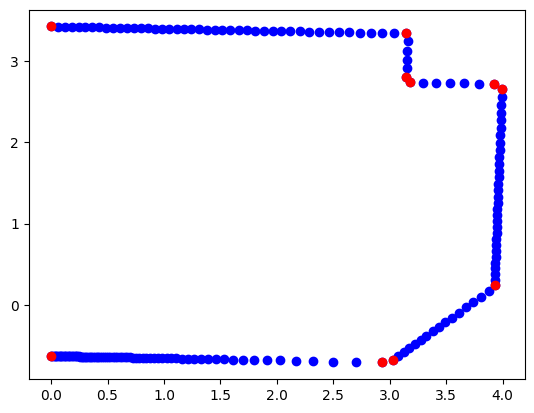

In [13]:
plt.plot(lidar_x, lidar_y, 'ob') # point cloud LiDAR
plt.plot(lidar_corners[:,0], lidar_corners[:,1], 'or') # features do LiDAR
plt.show()

## Analise dos dados da IMU

In [14]:
# Leitura do acelerometro
imu.linear_acceleration.z # m/s2

9.811641072193884

In [15]:
# TODO: Leitura do giroscopio (rad/s)

## Funções auxiliares para robótica

In [16]:
def qua2eul(q):
    '''
    Convert a quaternion into euler angles (roll, pitch, yaw)
    - roll is rotation around x in radians (counterclockwise)
    - pitch is rotation around y in radians (counterclockwise)
    - yaw is rotation around z in radians (counterclockwise)
    Ref: https://automaticaddison.com/how-to-convert-a-quaternion-into-euler-angles-in-python/
    '''
    
    x, y, z, w = q # Quaternion formatted as (x, y, z, w)
    
    t0 = 2.0 * (w * x + y * z)
    t1 = 1.0 - 2.0 * (x**2 + y**2)
    x_roll = np.arctan2(t0, t1)
 
    t2 = 2.0 * (w * y - z * x)
    t2 = 1.0 if t2 > 1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    y_pitch = np.arcsin(t2)
 
    t3 = 2.0 * (w*z + x*y)
    t4 = 1.0 - 2.0 * (y**2 + z**2)
    z_yaw = np.arctan2(t3, t4)
 
    return x_roll, y_pitch, z_yaw # in radians

def angle2rotm(angle):
    '''
    Returns a rotation matrix given an angle
    '''
    rotm = np.array([[np.cos(angle), -np.sin(angle)], \
                    [np.sin(angle),  np.cos(angle)]])
    return rotm

def pi_2_pi(angle):
    '''
    Mantém os ângulos entre -pi e pi
    '''
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [17]:
# Reference: https://answers.ros.org/question/358686/how-to-read-a-bag-file-in-ros2/

PATH_DATASET = './albot_tours0'
robot = Robot()
sensor = Sensor()

robot.pos = [] # posicao
robot.ori = [] # orientacao
robot.linear = [] # velocidade linear
robot.angular = [] # velocidade angular
sensor.lidar = []

typestore = get_typestore(Stores.ROS2_FOXY)

ticks = []
odom_timestamp = np.empty(0)
lidar_timestamp = np.empty(0)

# create reader instance and open for reading
with Reader(PATH_DATASET) as reader:
    # topic and msgtype information is available on .connections list
    # for connection in reader.connections:
    #     print(connection.topic, connection.msgtype)

    # iterate over messages
    for k, (connection, timestamp, rawdata) in enumerate(reader.messages()):
        if connection.topic == '/odom':
            odom = typestore.deserialize_cdr(rawdata, connection.msgtype)

            #================================================
            # Timestamp (em segundos) -> fs = 100 Hz
            #================================================
            odom_timestamp = np.hstack((odom_timestamp, odom.header.stamp.nanosec * 1e-9))
            ticks.append([connection.topic, odom.header.stamp.nanosec * 1e-9])
            
            #================================================
            # Odometria (posicao e orientacao)
            #================================================
            # Posição (x, y, z)
            robot.pos.append([odom.pose.pose.position.x, \
                              odom.pose.pose.position.y, \
                              odom.pose.pose.position.z])

            # Orientação em quaternion (padrão ROS)
            robot.q = np.array([odom.pose.pose.orientation.x, \
                                odom.pose.pose.orientation.y, \
                                odom.pose.pose.orientation.z, \
                                odom.pose.pose.orientation.w])

            # Orientação em ângulos de Euler (x_roll, y_pitch, z_yaw)
            robot.ori.append(qua2eul(robot.q))

            #================================================
            # Comandos do robô
            #================================================
            # Velocidade linear
            robot.linear.append([odom.twist.twist.linear.x, \
                                 odom.twist.twist.linear.y, \
                                 odom.twist.twist.linear.z])
            
            # Velocidade angular
            robot.angular.append([odom.twist.twist.angular.x, \
                                  odom.twist.twist.angular.y, \
                                  odom.twist.twist.angular.z])

        if connection.topic == '/scan':
            lidar = typestore.deserialize_cdr(rawdata, connection.msgtype)
            #================================================
            # Timestamp (em segundos) -> fs = 10 Hz
            #================================================
            lidar_timestamp = np.hstack((lidar_timestamp, lidar.header.stamp.nanosec * 1e-9))
            ticks.append([connection.topic, lidar.header.stamp.nanosec * 1e-9])

            #================================================
            # Leitura do LiDAR
            #================================================
            lidar_angles = np.arange(lidar.angle_min, \
                                     lidar.angle_max + lidar.angle_increment, \
                                     lidar.angle_increment) # radianos
            sensor.lidar.append([lidar.ranges, \
                                 lidar_angles])

# List2Array
robot.pos = np.array(robot.pos)
robot.ori = np.array(robot.ori)
robot.linear = np.array(robot.linear)
robot.angular = np.array(robot.angular)
sensor.lidar = np.array(sensor.lidar)

## 1. Corrompendo os dados da odometria

A odometria dada pelo ROS é livre de erros, portanto servirá como ground truth.

Já os dados dos sensores de velocidades linear e angular (giroscópio e acelerômetro, respectivamente) são sujeitos de erro, já simulado pelo ROS, conforme se aprecia nos gráficos embaixo.

In [18]:
# Criamos um novo dataset para criar dados de odometria
# corrompidos artificialmente
robot_noisy = Robot()
robot_noisy.pos = robot.pos.copy()
robot_noisy.ori = robot.ori.copy()

# Corrompendo posicao e orientacao com ruido AWGN
N = robot.pos.shape[0]
robot_noisy.pos += np.random.randn(N, 3) * 5e-2 # Intensidade de ruido: 5cm (em X, Y, Z)
robot_noisy.ori += np.random.randn(N, 3) * np.deg2rad(2) # Intensidade de ruido: 2 graus (em X, Y, Z)

In [19]:
# Vetor de tempo da odometria
fs_odom = 100.0 # Hz
t_odom = np.arange(len(robot.pos)) / fs_odom
# shift = 1
# odom_shift = odom_timestamp[shift:] - odom_timestamp[:-shift]
# t_odom = odom_timestamp[1] + np.cumsum(odom_shift)

# Vetor de tempo do LiDAR
fs_lidar = 10.0 # Hz
t_lidar = np.arange(len(lidar.ranges)) / fs_lidar
# shift = 1
# lidar_shift = lidar_timestamp[shift:] - lidar_timestamp[:-shift]
# t_lidar = lidar_timestamp[1] + np.cumsum(lidar_shift)

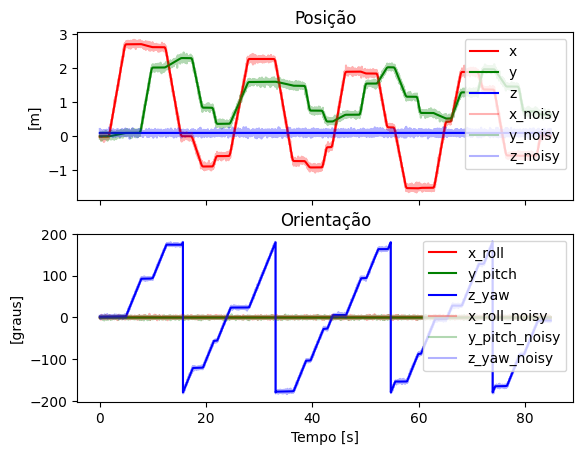

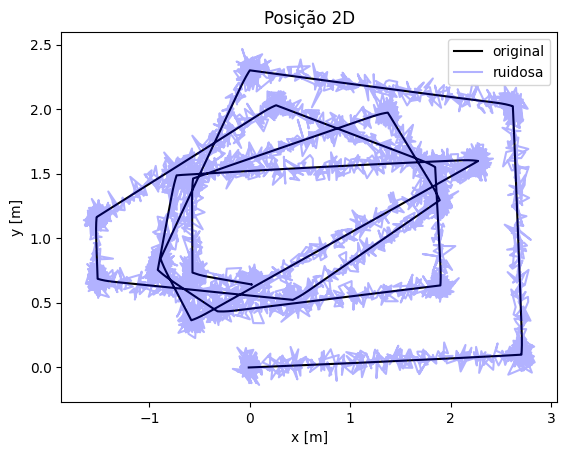

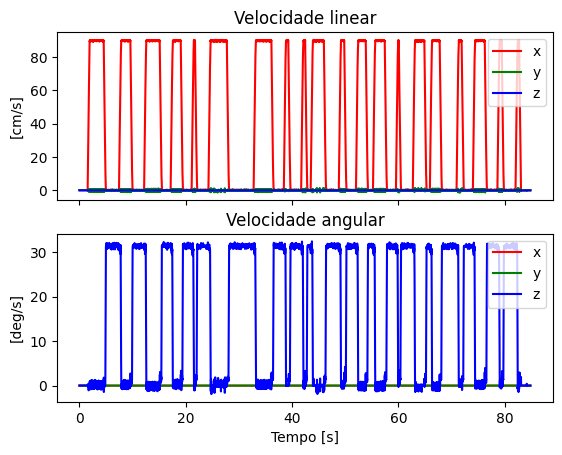

In [20]:
fig, axs = plt.subplots(2, 1, sharex='all')
axs[0].set_title('Posição')
axs[0].set_ylabel('[m]')
axs[0].set_prop_cycle('color', ['r', 'g', 'b'])
axs[0].plot(t_odom, robot.pos[:, 0], label='x')
axs[0].plot(t_odom, robot.pos[:, 1], label='y')
axs[0].plot(t_odom, robot.pos[:, 2], label='z')
axs[0].plot(t_odom, robot_noisy.pos[:, 0], alpha=0.3, label='x_noisy')
axs[0].plot(t_odom, robot_noisy.pos[:, 1], alpha=0.3, label='y_noisy')
axs[0].plot(t_odom, robot_noisy.pos[:, 2], alpha=0.3, label='z_noisy')
axs[0].legend(loc='upper right')

axs[1].set_title('Orientação')
axs[1].set_ylabel('[graus]')
axs[1].set_xlabel('Tempo [s]')
axs[1].set_prop_cycle('color', ['r', 'g', 'b'])
axs[1].plot(t_odom, np.rad2deg(robot.ori[:, 0]), label='x_roll')
axs[1].plot(t_odom, np.rad2deg(robot.ori[:, 1]), label='y_pitch')
axs[1].plot(t_odom, np.rad2deg(robot.ori[:, 2]), label='z_yaw')
axs[1].plot(t_odom, np.rad2deg(robot_noisy.ori[:, 0]), alpha=0.3, label='x_roll_noisy')
axs[1].plot(t_odom, np.rad2deg(robot_noisy.ori[:, 1]), alpha=0.3, label='y_pitch_noisy')
axs[1].plot(t_odom, np.rad2deg(robot_noisy.ori[:, 2]), alpha=0.3, label='z_yaw_noisy')
axs[1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots()
ax.set_title('Posição 2D')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.plot(robot.pos[:, 0], robot.pos[:, 1], c='k', label='original')
ax.plot(robot_noisy.pos[:, 0], robot_noisy.pos[:, 1], c='b', alpha=0.3, label='ruidosa')
ax.legend(loc='upper right')
plt.show()

fig, axs = plt.subplots(2, 1, sharex='all')
axs[0].set_title('Velocidade linear')
axs[0].set_ylabel('[cm/s]')
axs[0].set_prop_cycle('color', ['r', 'g', 'b'])
axs[0].plot(t_odom, robot.linear[:, 0] * 1e2, label='x')
axs[0].plot(t_odom, robot.linear[:, 1] * 1e2, label='y')
axs[0].plot(t_odom, robot.linear[:, 2] * 1e2, label='z')
axs[0].legend(loc='upper right')

axs[1].set_title('Velocidade angular')
axs[1].set_xlabel('Tempo [s]')
axs[1].set_ylabel('[deg/s]')
axs[1].set_prop_cycle('color', ['r', 'g', 'b'])
axs[1].plot(t_odom, np.rad2deg(robot.angular[:, 0]), label='x')
axs[1].plot(t_odom, np.rad2deg(robot.angular[:, 1]), label='y')
axs[1].plot(t_odom, np.rad2deg(robot.angular[:, 2]), label='z')
axs[1].legend(loc='upper right')
plt.show()

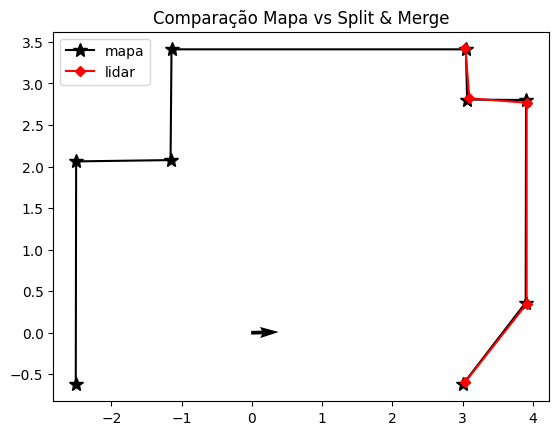

In [21]:
k = 0
ranges = sensor.lidar[k, 0, :]
angles = sensor.lidar[k, 1, :]
P = Polar2Cartesian(ranges, angles)
corners = SplitAndMerge(P, threshold=0.3)
corners = corners[1:-1] # Retiramos o primeiro e último valor dos cantos estimados

x, y  = robot.pos[9*(k+1), 0:2]
theta = robot.ori[9*(k+1), 2]
rotm = angle2rotm(theta)

x_lidar, y_lidar = np.array([[x, y]]).T + rotm @ corners.T

fig, ax = plt.subplots()
ax.set_title('Comparação Mapa vs Split & Merge')
ax.plot(landmarks[:, 0] , landmarks[:, 1], marker='*', c='k', markersize=10, label='mapa')
ax.plot(x_lidar, y_lidar, marker='D', c='r', markersize=5, label='lidar')
ax.quiver(x, y, rotm[0, 0], rotm[1, 0])
ax.legend()
plt.show()

### Filtro de Kalman

In [22]:
def motion_model(x, u, T):
    '''
    Modelo de movimento para atualização da pose do robô (posição e orientação)
    a partir do modelo cinématico
    '''
    F = np.array([[1.0,   0,   0],
                  [  0, 1.0,   0],
                  [  0,   0, 1.0]])

    B = np.array([[np.cos(x[2, 0]) * T,  0],
                  [np.sin(x[2, 0]) * T,  0],
                  [0                   , T]])

    x = ...
    
    return x

In [23]:
def jacob_motion(x, u, T):
    '''
    Jacobiano do modelo de movimento (aproximação por Taylor)
    '''

    jF = np.array([[1.0, 0.0, -T * u[0, 0] * np.sin(x[2, 0])],
                   [0.0, 1.0,  T * u[0, 0] * np.cos(x[2, 0])],
                   [0.0, 0.0,                           1.0]])

    return jF

In [24]:
def predict(x, P, u, T, R):
    '''
    Fase de predição do Filtro de Kalman
    '''

    jF = jacob_motion(x, u, T)
    
    x = motion_model(x, u, T)
    P = ...

    return x, P, jF

In [25]:
def jacobH(q, delta):
    '''
    Jacobiano do modelo do sensor (matriz H)
    '''
    
    sq = np.sqrt(q)
    H = np.array([[-delta[0, 0]/sq, -delta[1, 0]/sq,  0], \
                  [ delta[1, 0]/q , -delta[0, 0]/q,  -1]])

    return H

In [26]:
def calc_innovation(lm, x, P, z):
    '''
    Calculo da inovação
    '''
    
    delta = lm - x[0:2]
    q = (delta.T @ delta)[0, 0]
    zangle = np.arctan2(delta[1, 0], delta[0, 0]) - x[2, 0]

    # Modelo do sensor
    zp = ...
    
    # Inovação (S)
    y = (z - zp).T
    y[1] = pi_2_pi(y[1])

    H = jacobH(q, delta)
    S = ...

    return y, S, H, zp

In [27]:
def update(x, P, z, real_corners):
    '''
    Fase de atualização do Filtro de Kalman
    Corrige a estimativa da pose do robô com base nas observações do LiDAR
    '''
    
    minids = []
    for k in range(len(z[:, 0])):  # for each observation
        lm = real_corners.T[:, [k]]
        y, S, H, zp = calc_innovation(lm, x, P, z[k, :])
        # Ganho de Kalman
        K = ...

        # Estimativa
        x = ...
        P = ...

    # Normalizacao do angulo
    x[2] = pi_2_pi(x[2])
    
    return x, P, minids

In [28]:
def data_association(corners, mapa):
    '''
    Realiza correspôdencia entre o mapa e as features
    do Split and Merge
    '''

    match_ids = []
    for lidar_corner in corners:
        dists = []
        for real_corner in mapa:
            dists.append(np.sqrt(np.sum((lidar_corner - real_corner)**2)))

        match_id = dists.index(min(dists))
        match_ids.append(match_id)

    return mapa[match_ids, :], match_ids

In [29]:
def observation(corners):
    '''
    Retorna a estimativa das observações apartir das features
    do Split and Merge
    '''

    z = np.zeros((0, 2))

    for i in range(len(corners[:, 0])):
        dx = corners[i, 0]
        dy = corners[i, 1]
        d = np.sqrt(dx**2 + dy**2)
        angle = pi_2_pi(np.arctan2(dy, dx))
        zi = np.array([d, angle])
        z = np.vstack((z, zi))

    return z

In [30]:
#================================================
# Inicializando o sistema
#================================================

# Estado real
x = ...
x_hist = x # histórico de x

# Estado estimado (xhat) e covarianca (Phat)
xhat = ...
Phat = ...
xhat_hist = xhat # histórico de xhat

# Covariancia do modelo do sistema (x, y, theta)
R = ...

# Covariancia do modelo do LiDAR (range and bearing)
Q = ...

id_lidar = 0
id_odom = 1
ti = ticks[0][1] # initial timestamp (nanoseconds)

for k, (topic, tf) in tqdm.tqdm(enumerate(ticks[1:]), total=len(ticks[1:])):
    #================================================
    # Tempo do ciclo [T] (cycle time)
    #================================================
    T = 1/100.0

    #================================================
    # Fase de predição
    #================================================
    if topic == '/odom': # fs = 100 Hz
        # Estado real
        x = np.hstack([robot.pos[id_odom, 0:2], \
                       robot.ori[id_odom, 2]])[:, np.newaxis]
        
        # Vetor de entradas:
        # . Velocidade linear (no eixo X apenas)
        # . Velocidade angular (no eixo Z apenas)
        u = np.array([[robot.linear[id_odom, 0], \
                       robot.angular[id_odom, 2]]]).T

        xhat, Phat, jF = predict(xhat, Phat, u, T, R)

        id_odom += 1

    #================================================
    # Fase de atualização
    #================================================
    elif topic == '/scan': # fs = 10 Hz
        #===============================================
        #              Split and Merge
        #===============================================
        lidar_ranges = sensor.lidar[id_lidar, 0, :]
        lidar_angles = sensor.lidar[id_lidar, 1, :]
        P = Polar2Cartesian(lidar_ranges, lidar_angles)
        corners = SplitAndMerge(P, threshold=0.1)
        # HINT: Observe as quinas estimas e veja se precisa de algum pos-processamento adicional
        z = observation(corners) # predicao das observacoes

        #===============================================
        #              Correspondência
        #===============================================
        # Rotação e translação das features extraidas do lidar para coordenadas globais
        rotm = angle2rotm(xhat[2, 0])
        real_corners, ids = data_association((rotm @ corners.T).T + xhat[0:2, 0], landmarks)

        #===============================================
        #              Atualização
        #===============================================
        xhat, Phat, minids = update(xhat, Phat, z, real_corners)
        id_lidar += 1

    x_hist = np.hstack((x_hist, x))
    xhat_hist = np.hstack((xhat_hist, xhat))

  0%|                                                            | 0/9329 [00:00<?, ?it/s]


TypeError: 'ellipsis' object is not subscriptable

In [ ]:
fig, ax = plt.subplots()
ax.plot(landmarks[:, 0], landmarks[:, 1], c='k', marker='*', markersize=10, mec='k', mfc='gray')
ax.plot(0, 0, marker='>', markersize=15, mec='k', mfc='gray', label=r'$x_0$')
ax.plot(xhat_hist[0,0], xhat_hist[1,0], marker='>', markersize=15, mec='r', mfc='orange', label=r'$\hat{x}_0$')
ax.plot(x_hist[0,:], x_hist[1,:], c='k', linestyle='-', lw=1.0, alpha=1.0, label=r'$x$')
ax.plot(xhat_hist[0,::300], xhat_hist[1,::300], c='r', marker='o', markersize=5, linestyle='--', lw=1.5, alpha=1.0, label=r'$\hat{x}$')
ax.legend()
plt.show()